<a href="https://colab.research.google.com/github/SayaliDeodikar/PCOS_Detection_System/blob/main/numpy_conversion_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import cv2
import os

In [ ]:
data_dir = "/kaggle/input/clean-data/content/data/train"
CATEGORIES = ['infected', 'notinfected']
IMG_SIZE = 224

In [ ]:
training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(data_dir, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(e)
create_training_data()

In [ ]:
# training_data

In [ ]:
import random 
random.shuffle(training_data)

In [ ]:
X = []
Y = []

for categories, label in training_data:
    X.append(categories)
    Y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
X.shape

(1924, 224, 224, 3)

1


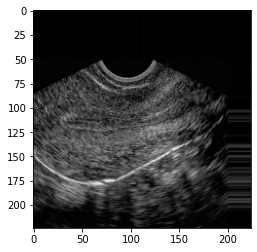

In [ ]:
X1 = X.reshape(X.shape[0], IMG_SIZE, IMG_SIZE, 3)
plt.imshow(X1[4])
print(Y[4]) 
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = (Y))

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, stratify = (Y_train))

In [ ]:
X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_test = np.asarray(X_test, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

X_val = np.asarray(X_val, dtype=np.float32)
Y_val = np.asarray(Y_val, dtype=np.float32)

In [ ]:
unique, counts = np.unique(Y_train, return_counts = True)
print("The train categories distribution is:\n", dict(zip(unique, counts)))
unique, counts = np.unique(Y_test, return_counts = True)
print("The test categories distribution is:\n", dict(zip(unique, counts)))
unique, counts = np.unique(Y_val, return_counts = True)
print("The val categories distribution is:\n", dict(zip(unique, counts)))

The train categories distribution is:
 {0.0: 500, 1.0: 731}
The test categories distribution is:
 {0.0: 156, 1.0: 229}
The val categories distribution is:
 {0.0: 125, 1.0: 183}


In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

In [ ]:
#Dimension of the dataset
print("Train set:\n",(X_train.shape,Y_train.shape))
print("Validation set:\n",(X_val.shape,Y_val.shape))
print("Test set:\n",(X_test.shape,Y_test.shape))

Train set:
 ((1231, 224, 224, 3), (1231, 2))
Validation set:
 ((308, 224, 224, 3), (308, 2))
Test set:
 ((385, 224, 224, 3), (385, 2))


In [ ]:
train_generator = ImageDataGenerator(rotation_range=5,
                                     horizontal_flip=True,
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     shear_range=0.5,
                                     zoom_range=0.5,
                                    fill_mode='nearest'
                                    )

In [ ]:
train_generator.fit(X_train)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam

In [ ]:
IMG_SHAPE = X_train[0].shape
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False

In [ ]:
model= Sequential()
model.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.add(Dense(64,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(32,activation=('relu')))
model.add(Dropout(.3))

# final layer
model.add(Dense(2,activation=('softmax')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 2)


Model summary:
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________

In [ ]:
#Initializing the hyperparameters
batch_size= 16
initial_epochs=20
learn_rate=0.001
adam = Adam(learning_rate=learn_rate)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator.flow(X_train, Y_train, batch_size= batch_size),
                    epochs=initial_epochs,
                    validation_data=(X_val,Y_val),
                    steps_per_epoch=10,
                    validation_steps=len(X_val),
                    verbose = 1)

Epoch 1/20
10/10 [==============================] - 4s 410ms/step - loss: 1.0254 - accuracy: 0.5723 - val_loss: 0.5768 - val_accuracy: 0.6364
Epoch 2/20
10/10 [==============================] - 5s 518ms/step - loss: 0.7966 - accuracy: 0.6062 - val_loss: 0.5193 - val_accuracy: 0.8052
Epoch 3/20
10/10 [==============================] - 4s 415ms/step - loss: 0.6477 - accuracy: 0.6375 - val_loss: 0.4396 - val_accuracy: 0.9643
Epoch 4/20
10/10 [==============================] - 4s 428ms/step - loss: 0.5794 - accuracy: 0.6750 - val_loss: 0.3676 - val_accuracy: 0.9610
Epoch 5/20
10/10 [==============================] - 4s 413ms/step - loss: 0.5456 - accuracy: 0.7063 - val_loss: 0.3556 - val_accuracy: 0.9870
Epoch 6/20
10/10 [==============================] - 4s 414ms/step - loss: 0.4421 - accuracy: 0.7875 - val_loss: 0.2587 - val_accuracy: 0.9870
Epoch 7/20
10/10 [==============================] - 5s 482ms/step - loss: 0.4882 - accuracy: 0.7375 - val_loss: 0.2082 - val_accuracy: 0.9675
Epoch 

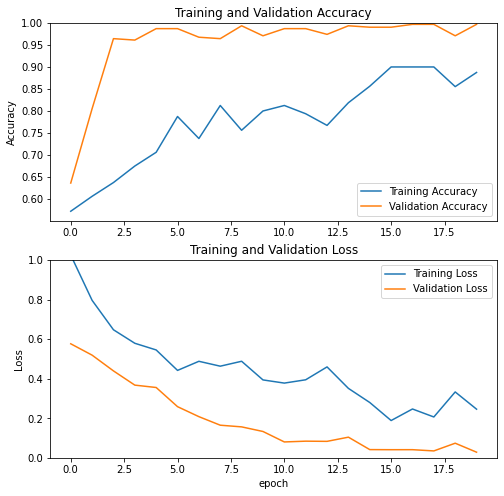

25/25 [==============================] - 1s 41ms/step - loss: 0.0224 - accuracy: 1.0000
Model accuracy on test set: 100.0%


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_ , accuracy = model.evaluate(x=X_test,y=Y_test,batch_size= batch_size,verbose=1)
print(f'Model accuracy on test set: {round(accuracy,3)*100}%')